In [3]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import math

%matplotlib widget


In [4]:


def get_sigma_points(sigma,units_vector):
    
    sampling_rate = 1/np.nanmean(np.diff(units_vector))
    sigma_points = sigma*sampling_rate
    return sigma_points

def generate_1d_gaussian_kernel(sigma, radius=None, truncate=4.0):
    """
    Generate a 1D Gaussian kernel with a specified standard deviation.

    Parameters:
        sigma (float): Standard deviation of the Gaussian kernel. 
        
            Notice that this is in data points and reflect the unit step.
            E.g., a if a time vector, given in seconds, is sampled at 20 Hz (one at each 5 ms),
            to get a sigma of 0.5 s, one need to convert it to points: 

            sampling_rate = np.nanmean(np.diff(time_vector))
            and then 
            sigma = 0.5*sampling_rate

            Since the kernel will convolute with the original signal, it will step through each point in a discrete way,
            and its wideness reflect the standard deviation: a higher std need more points than lower ones.
            
        radius (int, optional): Radius of the kernel. If None, computed as round(truncate * sigma).
        truncate (float, optional): Truncate the filter at this many standard deviations (default is 4.0).

    Returns:

        gaussian_kernel (numpy.ndarray): The normalized 1D Gaussian kernel (sums to 1).
        x_values (numpy.ndarray): The x-coordinates corresponding to the kernel values.
    """

    if sigma <= 0:
        raise ValueError("sigma must be positive")

    # Calculate radius if not provided
    if radius is None:
        radius = math.ceil(truncate * sigma)


    x_values = np.arange(-radius, radius + 1)
    dt = 1 # just making this more explicit
    constant = dt / (np.sqrt(2 * math.pi) * sigma)
    # We need to multiply by dt to normalize to area equal to one. Since here we have integer numbers meant to use as indexes, dt = 1
    kernel = constant * np.exp(-((x_values**2) / (2 * (sigma**2))))

    # The kernel should be normalized to sum to 1 (especially important for convolution to preserve signal 
    # magnitude). Currently, it's normalized for a continuous Gaussian (area=1), but in discrete form 
    # the sum may not be exactly 1.
    kernel /= kernel.sum()

    return kernel,x_values


def gaussian_smooth_1d(input_data, kernel, handle_nans=False):
    """
    Perform 1D Gaussian smoothing with mirror padding and proper NaN handling.
    
    Parameters:
        input_data (ndarray): 1D input array (may contain NaNs)
        kernel (ndarray): 1D Gaussian kernel (must be normalized to sum=1)
        handle_nans (bool): Whether to handle NaN values (default: True)
    
    Returns:
        ndarray: Smoothed data with original NaNs preserved
    """

    input_data = np.copy(input_data)
    if input_data.ndim != 1:
        raise ValueError("Input must be 1D array")
    
    if not handle_nans:
        # nan_mask = np.isnan(input_data)
        # input_data[nan_mask] = 0
        result = sig.convolve(input_data, kernel, mode='same', method='direct')
        # result[nan_mask] = np.nan
        return 
    
    # Create mask of valid numbers
    mask = ~np.isnan(input_data)
    data_clean = np.where(mask, input_data, 0)
    
    # Convolve both data and mask
    smoothed = sig.convolve(data_clean, kernel, mode='same', method='auto')
    norm_factor = sig.convolve(mask.astype(float), kernel, mode='same', method='auto')
    
    # Normalize and restore NaNs
    result = np.divide(smoothed, norm_factor, 
                      out=np.full_like(smoothed, np.nan), 
                      where=norm_factor > 1e-8)
    
    return result


def generate_2d_gaussian_kernel(sigma_x, sigma_y=None, radius_x=None, radius_y=None, truncate=4.0):
    """
    Generate 2D Gaussian kernel with rectangular support.
    
    Parameters:
        sigma_x (float): Standard deviation in x-direction (in pixels)
        sigma_y (float): Standard deviation in y-direction (optional)
        radius_x (int): Explicit x radius in pixels (optional)
        radius_y (int): Explicit y radius in pixels (optional)
        truncate (float): Number of sigmas to include (default: 4.0)
    
    Returns:
        kernel (ndarray): Normalized 2D Gaussian kernel
        (x_mesh, y_mesh) (tuple): Coordinate grids
    """
    if sigma_y is None:
        sigma_y = sigma_x
        
    # Calculate radii if not provided
    if radius_x is None:
        radius_x = math.ceil(truncate * sigma_x)
    if radius_y is None:
        radius_y = math.ceil(truncate * sigma_y)
    
    # Create coordinate ranges
    x = np.arange(-radius_x, radius_x + 1)
    y = np.arange(-radius_y, radius_y + 1)
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    # Compute 2D Gaussian
    # constant = (dt*dt) / (2 * np.pi * sigma_x * sigma_y) # since we are in 2D, we need to dt: dtx and dty

    constant = (1*1) / (2 * np.pi * sigma_x * sigma_y)
    kernel = constant * np.exp(-(x_mesh**2/(2*sigma_x**2) + y_mesh**2/(2*sigma_y**2)))
    kernel /= kernel.sum()  # Normalize
    
    return kernel, (x_mesh, y_mesh)
    
    
def gaussian_smooth_2d(matrix, kernel, handle_nans=False):
    """
    Convolve 2D matrix with mirror padding and NaN handling using convolve2d.
    
    Parameters:
        matrix (ndarray): Input 2D array (may contain NaNs)
        kernel (ndarray): 2D convolution kernel (must be square and normalized)
        handle_nans (bool): If True, properly handles NaN values (slower)
    
    Returns:
        ndarray: Convolved matrix (same shape as input) with NaNs preserved
    """
    matrix = np.copy(matrix)
    if handle_nans:
        # Create mask of valid numbers
        nan_mask = np.isnan(matrix)
        mask = ~nan_mask
        matrix_clean = np.nan_to_num(matrix)
        
        # Convolve both data and mask
        convolved = sig.convolve2d(matrix_clean, kernel, mode='same', boundary='fill')
        kernel_mask = sig.convolve2d(mask.astype(float), kernel, mode='same', boundary='fill')
        
        # Normalize and restore NaNs
        result = np.divide(convolved, kernel_mask, 
                         out=np.full_like(convolved, np.nan), 
                         where=kernel_mask > 1e-8)
        
        result[nan_mask] = np.nan
        return result
    else:
        # nan_mask = np.isnan(matrix)
        # matrix[nan_mask] = 0
        result = sig.convolve2d(matrix, kernel, mode='same', boundary='fill')
        # result[nan_mask] = np.nan

        return result


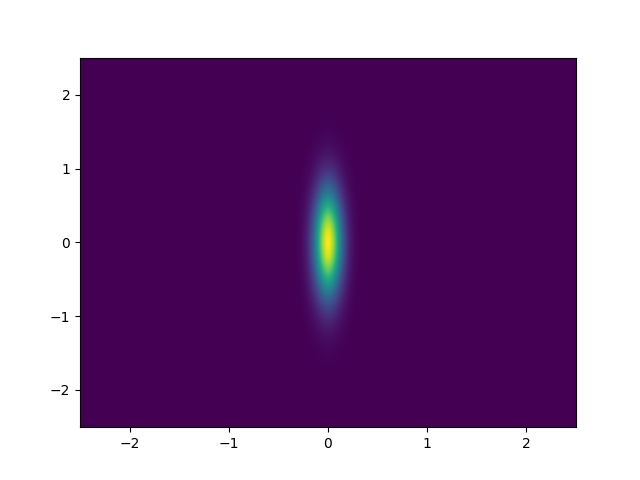

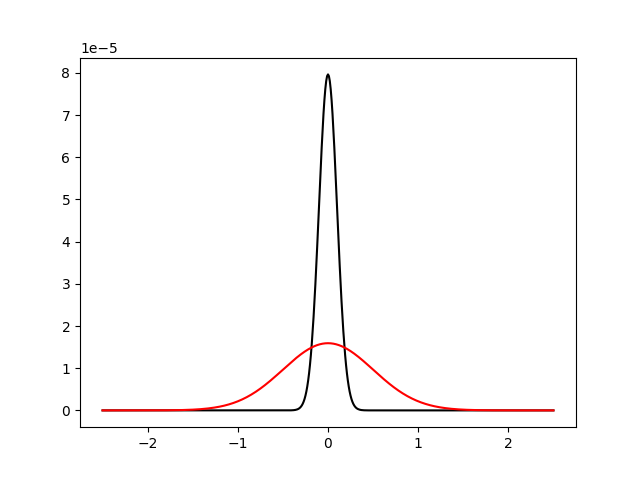

In [49]:
sigma_x = 0.1
sigma_y = 0.5
# continuous
sampling_rate = 100
dt = 1/sampling_rate
T = 5
x_vector = np.linspace(-T/2,T/2,T*sampling_rate + 1)
y_vector = np.linspace(-T/2,T/2,T*sampling_rate + 1)

# Create coordinate ranges
x_mesh, y_mesh = np.meshgrid(x_vector, y_vector)

# Compute 2D Gaussian
constant = (dt*dt) / (2 * np.pi * sigma_x * sigma_y)
kernel = constant * np.exp(-(x_mesh**2/(2*sigma_x**2) + y_mesh**2/(2*sigma_y**2)))
# kernel /= kernel.sum()  # Normalize

plt.figure()
plt.pcolormesh(x_mesh, y_mesh, kernel)
plt.show()
np.nansum(kernel)

plt.figure()
plt.plot(x_vector, np.nanmean(kernel,0),'k')
plt.plot(x_vector, np.nanmean(kernel,1),'r')

plt.show()

In [47]:
gaussian_kernel = np.nansum(kernel,0) # x kernel
# gaussian_kernel = np.nansum(kernel,1) # y kernel


Estimated σ: 0.10000000000000009


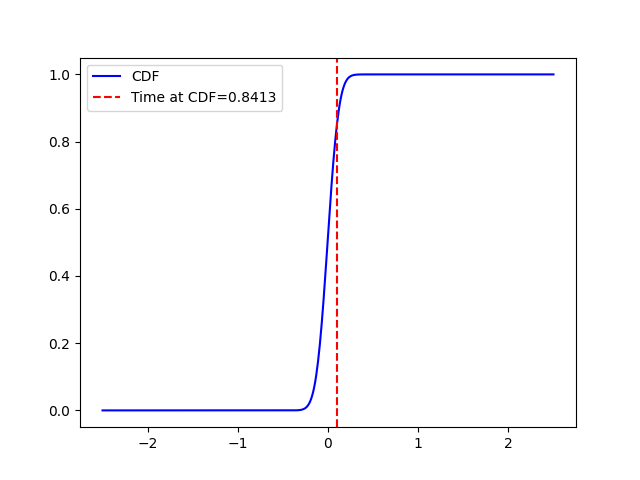

In [48]:
gaussian_kernel = np.nansum(kernel,0) # x kernel
# gaussian_kernel = np.nansum(kernel,1) # y kernel

# Step 1: Compute the CDF
cdf = np.cumsum(gaussian_kernel)
# cdf /= cdf[-1]  # Normalize to make it a proper CDF

# Step 2: Identify the time point where CDF ≈ 0.8413
target_cdf_value = 0.8413
index = np.searchsorted(cdf, target_cdf_value)
time_at_target = x_vector[index]

# Step 3: Calculate sigma
mu = 0  # For a symmetric Gaussian centered at zero
sigma_estimated = time_at_target - mu

print(f"Estimated σ: {sigma_estimated}")

# Optional: Plot the CDF
plt.figure()
plt.plot(x_vector, cdf, 'b', label='CDF')
plt.axvline(x=time_at_target, color='r', linestyle='--', label=f'Time at CDF={target_cdf_value}')
plt.legend()
plt.show()


In [ ]:
# now with discrete values

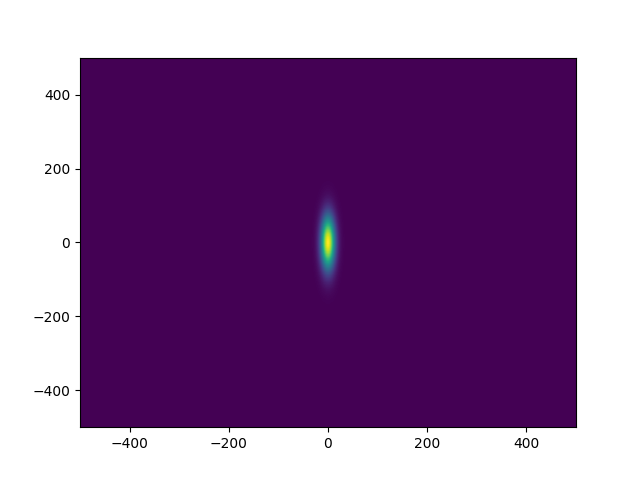

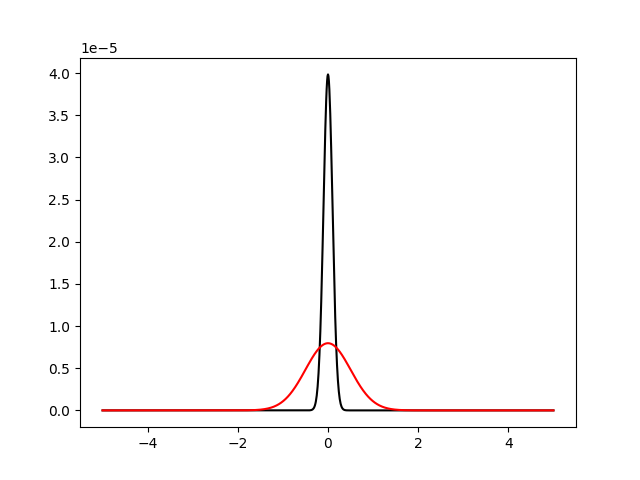

In [53]:
sigma_x = 0.1
sigma_y = 0.5

# continuous
sampling_rate = 100
dt = 1/sampling_rate


sigma_x_points = sigma_x*sampling_rate
sigma_y_points = sigma_y*sampling_rate

truncate = 10
radius_x = math.ceil(truncate * sigma_x_points)
radius_y = math.ceil(truncate * sigma_y_points)

# x = np.arange(-radius_x, radius_x + 1)
# y = np.arange(-radius_y, radius_y + 1)

radius = np.nanmax([radius_x,radius_y])

x = np.arange(-radius, radius + 1)
y = np.arange(-radius, radius + 1)

x_mesh, y_mesh = np.meshgrid(x, y)

# Compute 2D Gaussian
# constant = (dt*dt) / (2 * np.pi * sigma_x * sigma_y) # since we are in 2D, we need to dt: dtx and dty

constant = (1*1) / (2 * np.pi * sigma_x_points * sigma_y_points)
kernel = constant * np.exp(-(x_mesh**2/(2*sigma_x_points**2) + y_mesh**2/(2*sigma_y_points**2)))
# kernel /= kernel.sum()  # Normalize

plt.figure()
plt.pcolormesh(x_mesh, y_mesh, kernel)
plt.show()

plt.figure()
plt.plot(x/sampling_rate, np.nanmean(kernel,0),'k')
plt.plot(y/sampling_rate, np.nanmean(kernel,1),'r')
plt.show()


In [54]:
np.nansum(kernel)

np.float64(1.0)

Estimated σ: 0.5


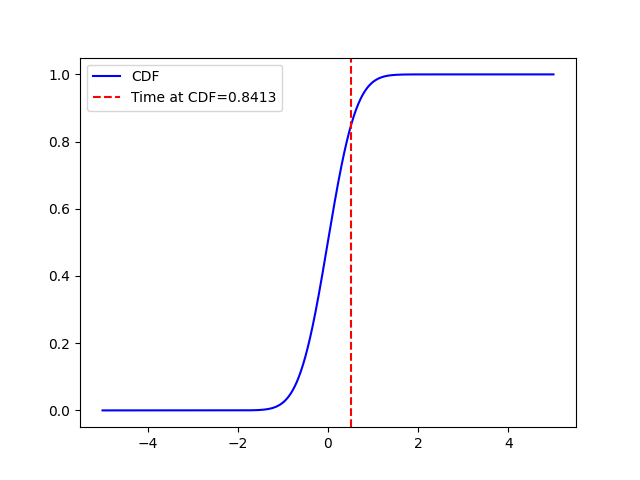

In [59]:
gaussian_kernel = np.nansum(kernel,0) # x kernel
gaussian_kernel = np.nansum(kernel,1) # y kernel

# Step 1: Compute the CDF
cdf = np.cumsum(gaussian_kernel)
# cdf /= cdf[-1]  # Normalize to make it a proper CDF

# Step 2: Identify the time point where CDF ≈ 0.8413
target_cdf_value = 0.8413
index = np.searchsorted(cdf, target_cdf_value)
time_at_target = x[index]/sampling_rate

# Step 3: Calculate sigma
mu = 0  # For a symmetric Gaussian centered at zero
sigma_estimated = time_at_target - mu

print(f"Estimated σ: {sigma_estimated}")

# Optional: Plot the CDF
plt.figure()
plt.plot(x/sampling_rate, cdf, 'b', label='CDF')
plt.axvline(x=time_at_target, color='r', linestyle='--', label=f'Time at CDF={target_cdf_value}')
plt.legend()
plt.show()


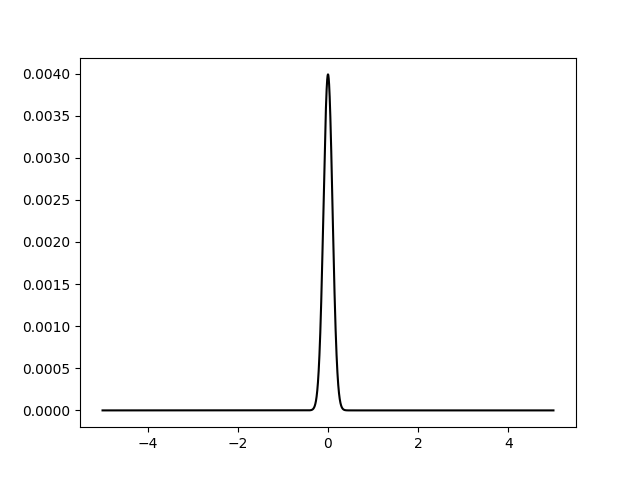

np.float64(1.0)

In [86]:
sigma = 0.1

# continuous
sampling_rate = 1000
dt = 1/sampling_rate
time_vector = np.linspace(-5,5,sampling_rate*10 + 1)

# constant = 1 / (np.sqrt(2 * math.pi) * sigma)
constant = dt / (np.sqrt(2 * math.pi) * sigma)  # multiply by dt (since it is discrete, this normalizes to area equal to one)
gaussian_kernel = constant * np.exp(-((time_vector**2) / (2 * (sigma**2))))
# gaussian_kernel_normalized = gaussian_kernel / np.sum(gaussian_kernel)

plt.figure()
plt.plot(time_vector,gaussian_kernel,'k-')
# plt.plot(time_vector,gaussian_kernel_normalized,'r-')

plt.show()

np.nansum(gaussian_kernel)


In [87]:

# Assuming 'time_vector' and 'gaussian_kernel' are already defined

# Step 1: Find the maximum value of the Gaussian kernel
max_value = np.max(gaussian_kernel)

# Step 2: Compute the half-maximum value
half_max = max_value / 2

# Step 3: Find indices where the Gaussian kernel crosses the half-maximum value
indices = np.where(gaussian_kernel >= half_max)[0]

# Step 4: Determine the FWHM
fwhm = time_vector[indices[-1]] - time_vector[indices[0]]

# Step 5: Calculate sigma
sigma_estimated = fwhm / 2.355

print(f"Estimated σ: {sigma_estimated}")


Estimated σ: 0.09936305732484076


In [50]:
# Step 1: Compute the CDF


Estimated σ: 0.10000000000000053


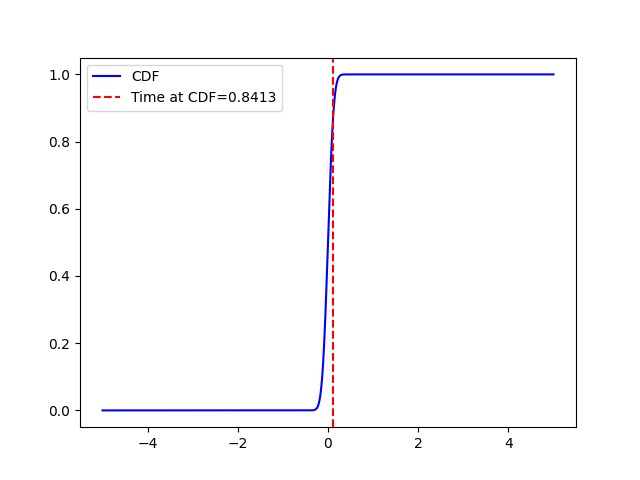

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'time_vector' and 'gaussian_kernel' are already defined

# Step 1: Compute the CDF
cdf = np.cumsum(gaussian_kernel)
# cdf /= cdf[-1]  # Normalize to make it a proper CDF

# Step 2: Identify the time point where CDF ≈ 0.8413
target_cdf_value = 0.8413
index = np.searchsorted(cdf, target_cdf_value)
time_at_target = time_vector[index]

# Step 3: Calculate sigma
mu = 0  # For a symmetric Gaussian centered at zero
sigma_estimated = time_at_target - mu

print(f"Estimated σ: {sigma_estimated}")

# Optional: Plot the CDF
plt.figure()
plt.plot(time_vector, cdf, 'b', label='CDF')
plt.axvline(x=time_at_target, color='r', linestyle='--', label=f'Time at CDF={target_cdf_value}')
plt.legend()
plt.show()


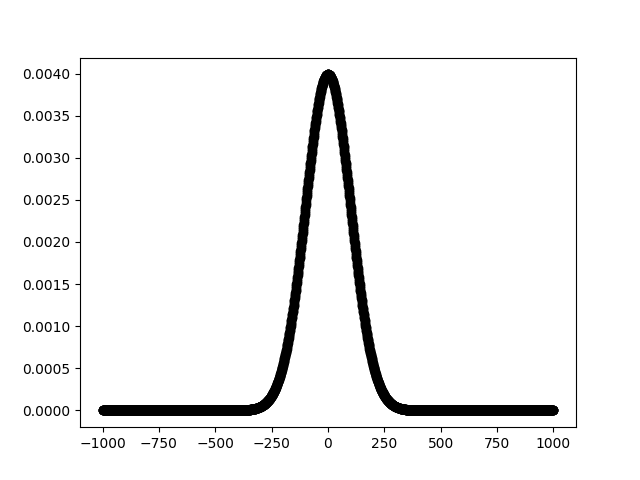

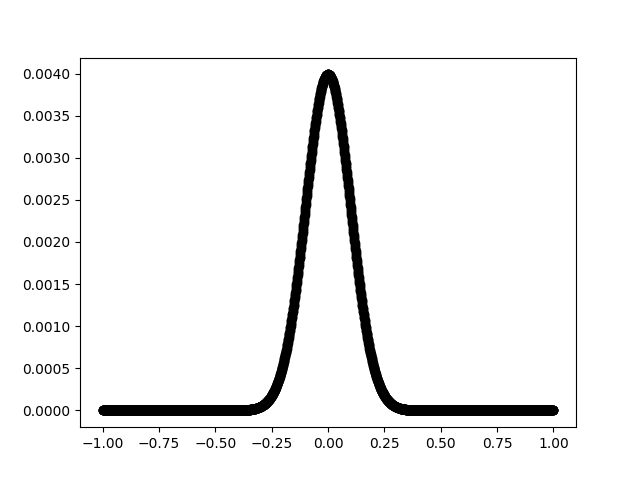

np.float64(1.0)

In [90]:
# in this "discrete" case, where we use integers, dt is already equal to 1

# time_vector from above
sigma = 0.1
sampling_rate = 1/np.nanmean(np.diff(time_vector))
sigma_points = sigma*sampling_rate

truncate = 10
radius = math.ceil(truncate * sigma_points)
radius


x_values = np.arange(-radius, radius + 1)
constant = 1 / (np.sqrt(2 * math.pi) * sigma_points)
gaussian_kernel = constant * np.exp(-((x_values**2) / (2 * (sigma_points**2))))

plt.figure()
plt.plot(x_values,gaussian_kernel,'k-o')
plt.show()

plt.figure()
plt.plot(x_values/sampling_rate,gaussian_kernel,'k-o')
plt.show()

np.nansum(gaussian_kernel)


Estimated σ: 0.1


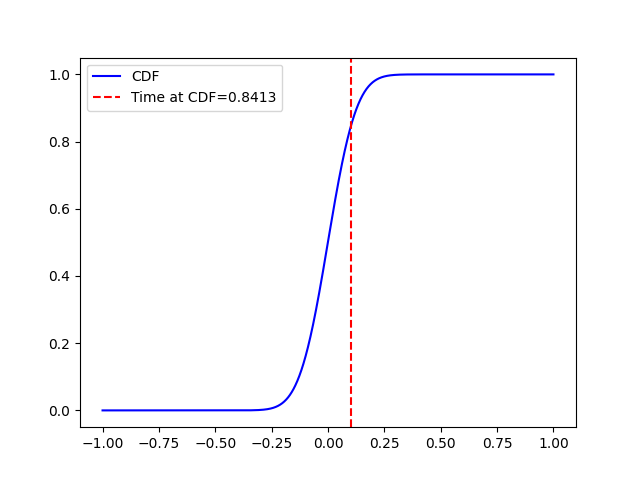

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'time_vector' and 'gaussian_kernel' are already defined

# Step 1: Compute the CDF
cdf = np.cumsum(gaussian_kernel)
# cdf /= cdf[-1]  # Normalize to make it a proper CDF
x_values_t = x_values/sampling_rate
# Step 2: Identify the time point where CDF ≈ 0.8413
target_cdf_value = 0.8413
index = np.searchsorted(cdf, target_cdf_value)
time_at_target = x_values_t[index]

# Step 3: Calculate sigma
mu = 0  # For a symmetric Gaussian centered at zero
sigma_estimated = time_at_target - mu

print(f"Estimated σ: {sigma_estimated}")

# Optional: Plot the CDF
plt.figure()
plt.plot(x_values_t, cdf, 'b', label='CDF')
plt.axvline(x=time_at_target, color='r', linestyle='--', label=f'Time at CDF={target_cdf_value}')
plt.legend()
plt.show()


In [ ]:
# This we prove that our integer (discrete) case is equal to continuous case.

In [154]:
sampling_rate = 1000
dt = 1/sampling_rate
timestamps_vector = np.arange(0,10,dt)
timestamps = np.zeros(timestamps_vector.shape[0])
timestamps[np.arange(100,5000,200)] = 1
timestamps[6000:7000] = np.nan


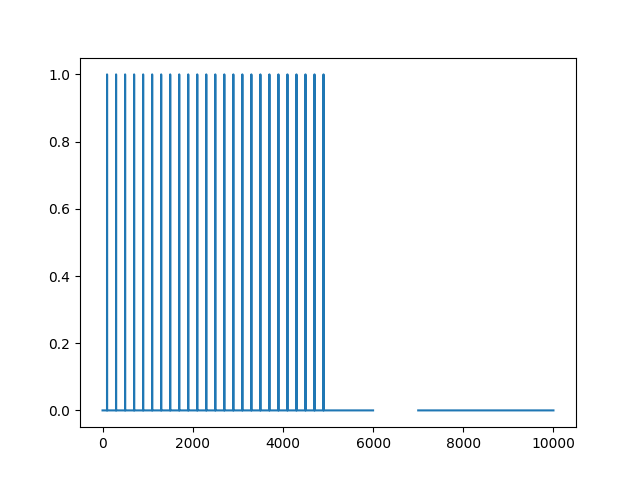

In [155]:

plt.figure()
plt.plot(timestamps)
plt.show()


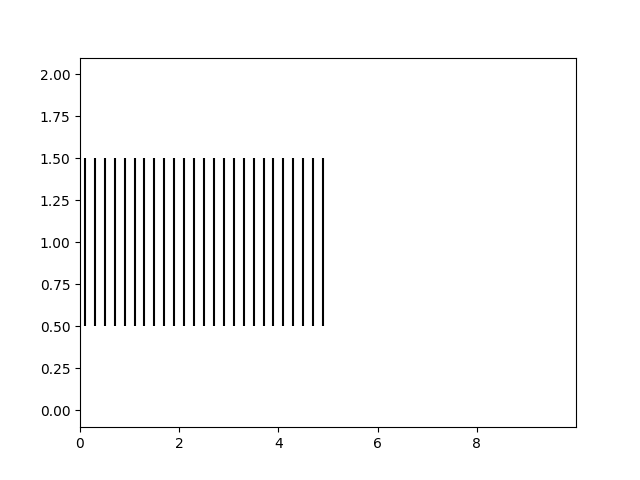

In [156]:

plt.figure()
plt.eventplot(timestamps_vector[timestamps==1],color='black')
plt.xlim([timestamps_vector[0],timestamps_vector[-1]])
plt.show()


In [157]:
sigma = 0.05
sampling_rate = 1/np.nanmean(np.diff(timestamps_vector))
sigma_points = sigma*sampling_rate

truncate = 10
radius = math.ceil(truncate * sigma_points)
radius


x_values = np.arange(-radius, radius + 1)
constant = 1 / (np.sqrt(2 * math.pi) * sigma_points)
gaussian_kernel = constant * np.exp(-((x_values**2) / (2 * (sigma_points**2))))
np.nansum(gaussian_kernel)

np.float64(1.0)

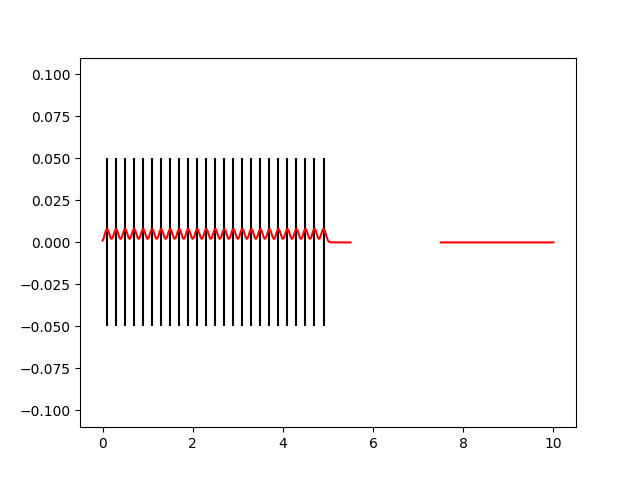

In [161]:
input_data = timestamps.copy()
# nan_mask = np.isnan(input_data)
# input_data[nan_mask] = 0
result = sig.convolve(input_data, gaussian_kernel, mode='same', method='direct')
# result[nan_mask] = np.nan


plt.figure()
plt.eventplot(timestamps_vector[timestamps==1],color='black',lineoffsets=0,linelengths=0.1)
plt.plot(timestamps_vector,result,'r')
# plt.ylim([-1,1])
# plt.xlim([timestamps_vector[0],timestamps_vector[-1]])
plt.show()


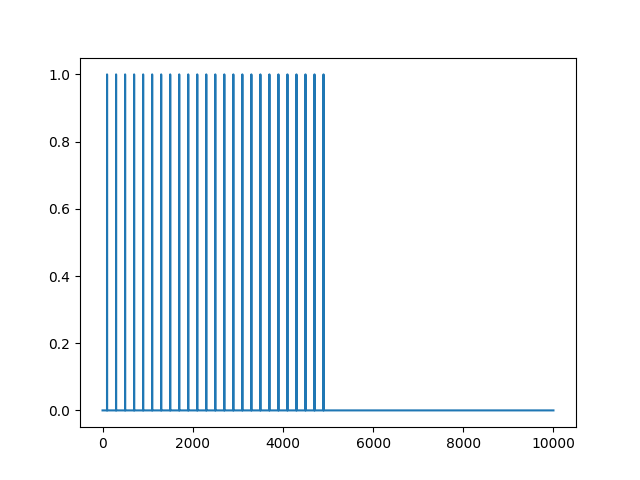

In [164]:
# Create mask of valid numbers
mask = ~np.isnan(input_data)
data_clean = np.where(mask, input_data, 0)

plt.figure()
plt.plot(data_clean)
plt.show()

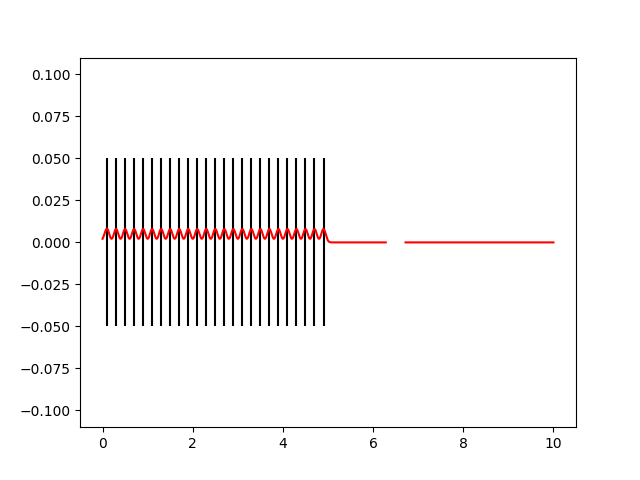

In [172]:

# Convolve both data and mask
smoothed = sig.convolve(data_clean, gaussian_kernel, mode='same', method='auto')
norm_factor = sig.convolve(mask.astype(float), gaussian_kernel, mode='same', method='auto')


# Normalize and restore NaNs
result = np.divide(smoothed, norm_factor, 
                  out=np.full_like(smoothed, np.nan), 
                  where=norm_factor > 1e-8)
plt.figure()
plt.eventplot(timestamps_vector[timestamps==1],color='black',lineoffsets=0,linelengths=0.1)
plt.plot(timestamps_vector,result,'r')
plt.show()
